# [Hands-On] Data to Number : Image to Numeric Representation

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

### Description

The recent significant success in artificial intelligence can be attributed to the ability to convert any type of data (text, image, voice, etc.) into a **numeric representation** that encapsulates sufficient information. This practice session is the **first in a series of two exercises** designed to introduce and provide *hands-on experience* with the 'Data to Number' concept.

In this practice, we will explore the process of converting image data into numerical form, known as Image to Number conversion.

This transformation can be achieved through various outcomes of representation learning based on neural networks, and can be readily implemented using either pre-trained neural networks or by training a neural network from scratch.

In this session, we will adopt the approach of training a neural network ourselves to digitize images. Specifically, we will utilize an autoencoder, a classic method of representation learning, to execute this task. By doing so, we aim to visualize the 'quantity of information' that has been learned through the process of reconstructing fruit images from their low-dimensional representations.

## Understanding Image Digitization with Autoencoders

This notebook aims to explore image digitization techniques with a focus on using autoencoders.
Autoencoders are a type of neural network used for unsupervised learning, ideal for dimensionality reduction and feature learning.

### Objective:
- To understand how images can be converted into numerical representations (embeddings) using autoencoders.
- To use the bottleneck hidden states of an autoencoder as image embeddings.

### Dataset:
- The 'Fruit Embedding Dataset' comprising training and testing folders, each containing subfolders for four types of fruits: Apple, Asian Pear, Banana, and Cherry. Each subfolder contains images of the respective fruit.

### Approach:
- Train an autoencoder on the dataset in an unsupervised manner without utilizing the fruit labels.
- Later, use t-SNE for clustering and visualize the clusters using the fruit label information for better interpretation.



## Import Necessary Libraries
Import the libraries needed for the project, such as PyTorch for building the autoencoder, matplotlib for visualization, and sklearn for t-SNE.

In [1]:
!pip install -q numpy==1.26.4 torch==2.5.1 pandas==2.2.2 matplotlib==3.10.0

In [2]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

## Load and Preprocess the Data
Load the dataset using PyTorch's datasets.ImageFolder and preprocess the images.

In [3]:
#!mkdir data
!rm data.zip
!rm -r data
!wget 'https://www.dropbox.com/scl/fi/mf806inzv0x6abbb2su0k/fruit-dataset.zip?rlkey=gk7s9d14m6k9o1ru4whrgtwke&dl=1' -O data.zip
!unzip data.zip -d fruit-dataset/

rm: cannot remove 'data.zip': No such file or directory
rm: cannot remove 'data': No such file or directory
--2025-03-08 05:02:48--  https://www.dropbox.com/scl/fi/mf806inzv0x6abbb2su0k/fruit-dataset.zip?rlkey=gk7s9d14m6k9o1ru4whrgtwke&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc91c0fe49e5c33f448f268a2a2f.dl.dropboxusercontent.com/cd/0/inline/CleCAaqZ2dilmhLEcQsCGy-3sVFaqKGP2TO1Kbj6lgiYW_nwg4_tiEWwMYEPsp27UnDwUIYr9qPkh84g0c_fS_WgYIHn4EhWoyqlhqy8cygDyd6KwYmFVPCGgRnZ4DFRwLs/file?dl=1# [following]
--2025-03-08 05:02:49--  https://uc91c0fe49e5c33f448f268a2a2f.dl.dropboxusercontent.com/cd/0/inline/CleCAaqZ2dilmhLEcQsCGy-3sVFaqKGP2TO1Kbj6lgiYW_nwg4_tiEWwMYEPsp27UnDwUIYr9qPkh84g0c_fS_WgYIHn4EhWoyqlhqy8cygDyd6KwYmFVPCGgRnZ4DFRwLs/file?dl=1
Resolving uc91c0fe49e5c33f448f268a2a2f.dl.dropboxusercon

In [4]:
# Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='./fruit-dataset/train', transform=transform)
test_dataset = datasets.ImageFolder(root='./fruit-dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Define the Autoencoder
Define your autoencoder architecture in PyTorch.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # Output: 128x128
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # Output: 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Output: 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Output: 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # Output: 8x8
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # Output: 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # Output: 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Output: 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # Output: 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # Output: 256x256
            nn.Sigmoid()  # Use sigmoid to scale the output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Autoencoder

<img src="https://miro.medium.com/max/3110/0*uq2_ZipB9TqI9G_k" alt="Autoencoder" width="600" height="auto">


## Train the Autoencoder
Train your autoencoder using the training data.

In [6]:
# Autoencoder Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20  # Adjust as needed
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 0.0448
Epoch [2/20], Loss: 0.0367
Epoch [3/20], Loss: 0.0281
Epoch [4/20], Loss: 0.0181
Epoch [5/20], Loss: 0.0114
Epoch [6/20], Loss: 0.0115
Epoch [7/20], Loss: 0.0112
Epoch [8/20], Loss: 0.0106
Epoch [9/20], Loss: 0.0093
Epoch [10/20], Loss: 0.0095
Epoch [11/20], Loss: 0.0077
Epoch [12/20], Loss: 0.0096
Epoch [13/20], Loss: 0.0085
Epoch [14/20], Loss: 0.0066
Epoch [15/20], Loss: 0.0070
Epoch [16/20], Loss: 0.0068
Epoch [17/20], Loss: 0.0092
Epoch [18/20], Loss: 0.0086
Epoch [19/20], Loss: 0.0071
Epoch [20/20], Loss: 0.0062


## Visualize Original and Reconstructed Images

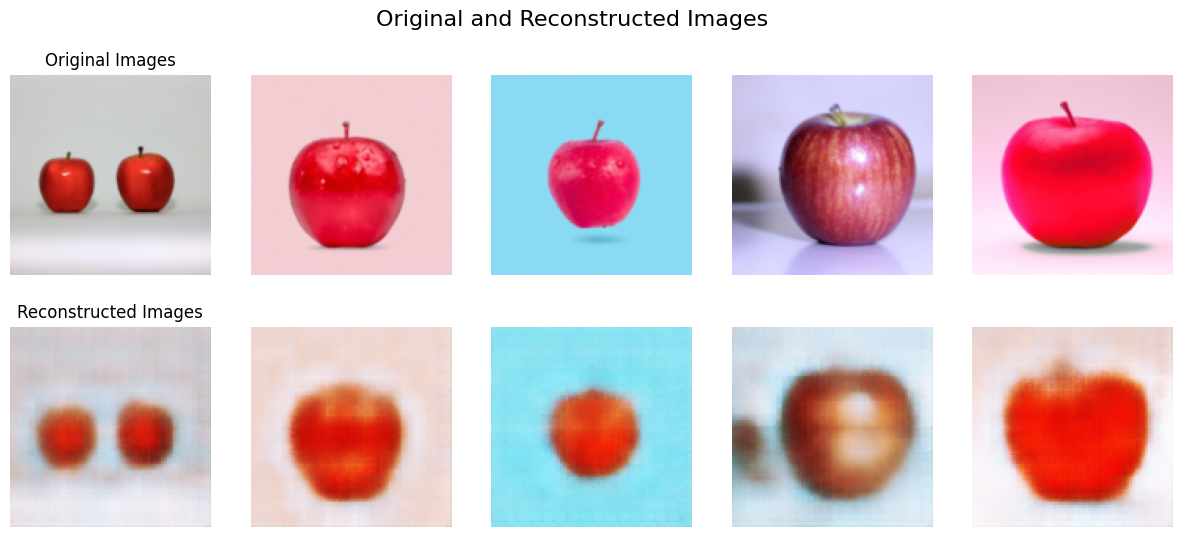

In [7]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Get a batch of test images
test_images, _ = next(iter(test_loader))

# Select the first 5 images
test_images = test_images[:5].to(device)

# Forward pass through the autoencoder to get the reconstructed images
with torch.no_grad():
    reconstructed = model(test_images)

# Move tensors to CPU for plotting
test_images = test_images.cpu()
reconstructed = reconstructed.cpu()

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle('Original and Reconstructed Images', fontsize=16)

for images, row in zip([test_images, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')

axes[0, 0].set_title('Original Images')
axes[1, 0].set_title('Reconstructed Images')
plt.show()


The illustration above demonstrates that while the neural network does not fully learn the complete form of the information, it captures some extent of the shape, color, and distinctive features of each fruit. These characteristics are encapsulated within the bottleneck representation, which then facilitates the reconstruction of the entire image.

## Generate Embeddings
Extract embeddings from the encoder part of the autoencoder.

In [8]:
# Generate Embeddings
def get_embeddings(dataloader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for data in dataloader:
            img, _ = data
            img = img.to(device)
            encoded_img = model.encoder(img) # shape [32, 256, 4, 4]
            embeddings.append(encoded_img.view(img.size(0), -1).cpu().numpy())
    return np.concatenate(embeddings)

test_embeddings = get_embeddings(test_loader)


In [9]:
print( "Original image shape :",  test_images[0].view(-1).shape) # 49152 = 128 x 128 x 3 (channel)
print( "Bottleneck image shape :",  test_embeddings[0].shape)
print( test_embeddings.shape ) # [len(test_dataset), dim]

Original image shape : torch.Size([49152])
Bottleneck image shape : (4096,)
(400, 4096)


## t-SNE Clustering and Visualization
Apply t-SNE on the embeddings and visualize them, using the fruit labels for color-coding.

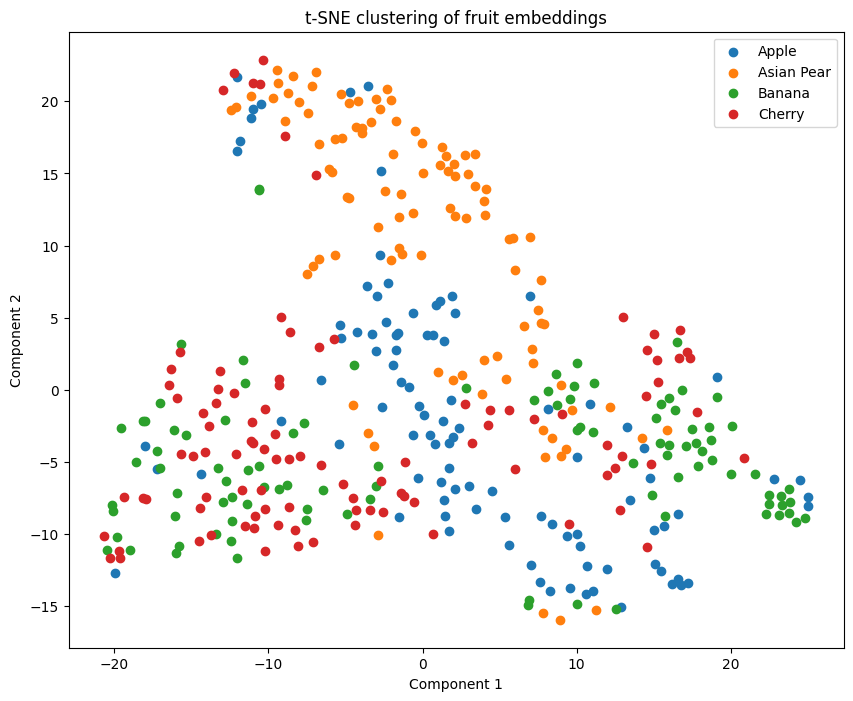

In [10]:
# t-SNE Clustering and Visualization
tsne = TSNE(n_components=2, random_state=42)
test_embeddings_2d = tsne.fit_transform(test_embeddings)

plt.figure(figsize=(10, 8))
for i, label in enumerate(['Apple', 'Asian Pear', 'Banana', 'Cherry']):
    indices = [idx for idx, val in enumerate(test_dataset.targets) if val == i]
    plt.scatter(test_embeddings_2d[indices, 0], test_embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE clustering of fruit embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

When visualized in two dimensions, the data is somewhat distinguishable, but there are still overlaps. Let's enhance the visualization by adding one more dimension, making it three-dimensional to better differentiate the data.

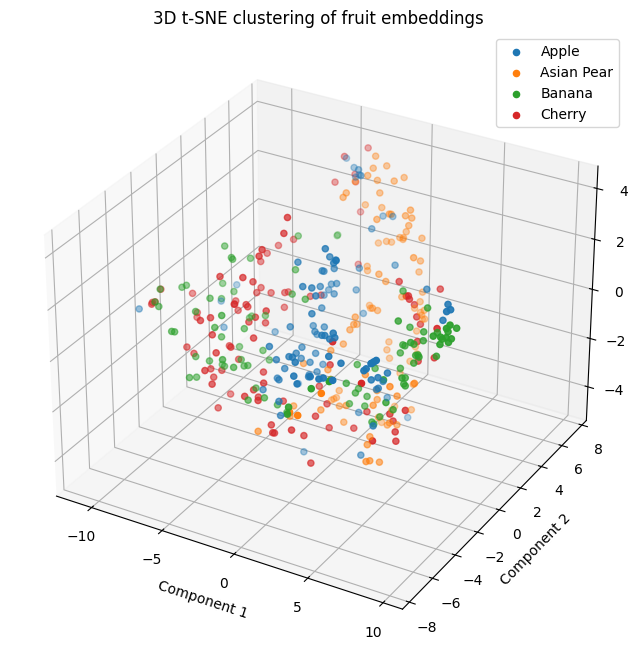

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# t-SNE Clustering and Visualization in 3D
tsne = TSNE(n_components=3, random_state=42)  # Set n_components to 3 for 3D visualization
test_embeddings_3d = tsne.fit_transform(test_embeddings)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

for i, label in enumerate(['Apple', 'Asian Pear', 'Banana', 'Cherry']):
    indices = [idx for idx, val in enumerate(test_dataset.targets) if val == i]
    ax.scatter(test_embeddings_3d[indices, 0], test_embeddings_3d[indices, 1], test_embeddings_3d[indices, 2], label=label)

ax.legend()
ax.set_title('3D t-SNE clustering of fruit embeddings')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()


It is observable that the data is relatively well differentiated. A point of note is that the method used to obtain the representation in this exercise was implemented using a **very simple technique**.

By employing a more sophisticated and well-structured neural network architecture (like ResNet, ViT, etc.), and adopting different learning methods other than the autoencoder-style reconstruction problem for the objective function, it is possible to capture a more informative set of numbers (representation).

## Conclusion

This hands-on exercise explored the transformation of image data into numerical representations using autoencoders. The key findings include:

### Key Results
- Successfully converted fruit images into low-dimensional embeddings using a simple autoencoder architecture
- Demonstrated that compressed representations retained essential information about shape, color, and distinctive features
- Visualized the embeddings using t-SNE, showing reasonable clustering of different fruit classes

### Insights
- Even with a simple architecture, the autoencoder captured sufficient information to reconstruct recognizable images
- The bottleneck representation significantly reduced dimensionality (from 49,152 to a much smaller vector) while preserving key visual characteristics
- The unsupervised learning approach effectively learned meaningful representations without using fruit labels

### Future Directions
More sophisticated neural architectures (ResNet, ViT) and alternative learning methods beyond reconstruction could further improve the quality and informativeness of these numerical representations.

This exercise provides a foundation for understanding the "Data to Number" concept that underlies recent advances in artificial intelligence applications.